In [1]:
# Guide from: https://matthew-parker.rbind.io/post/2021-01-16-pytorch-keras-clustering/
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import manifold

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras

In [2]:
games = pd.read_csv("games.csv")

In [6]:
games.sort_values(by="Positive", ascending=False)
games = games.head(10000)

In [7]:
games_features = games.copy().dropna()

In [8]:
games_features.pop("HeaderImage")
g_labels = games_features.pop("AppID")

In [9]:
features = {}
for ftr, col in games_features.items():
    dtype = col.dtype
    if dtype == object:
        dtype = tf.string
    else:
        dtype = tf.float32
    features[ftr] = tf.keras.Input(shape=(1,), name=ftr, dtype=dtype)

In [10]:
numeric_features = {name: input for name, input in features.items() if input.dtype == tf.float32}

x = tf.keras.layers.Concatenate()(list(numeric_features.values()))
norm = preprocessing.Normalization()
norm.adapt(np.array(games_features[numeric_features.keys()]))
all_numeric_features = norm(x)
pp_features = [all_numeric_features]

In [11]:
for ftr, content in features.items():
    if content.dtype != tf.string:
        continue

    lookup = preprocessing.StringLookup(vocabulary=np.unique(games_features[ftr]))
    one_hot = preprocessing.CategoryEncoding(max_tokens=lookup.vocab_size())

    x = lookup(content)
    x = one_hot(x)
    pp_features.append(x)

In [13]:
pp_features_cat = keras.layers.Concatenate()(pp_features)
pp_layer = tf.keras.Model(features, pp_features_cat, name="ProcessData")

In [14]:
games_features_dict = {name: np.array(value) for name, value in games_features.items()}

In [17]:
two_sample_dict = {name:values[1:3, ] for name, values in games_features_dict.items()}
two_sample_fitted = pp_layer(two_sample_dict)

In [18]:
full_dim = two_sample_fitted.shape.as_list()[1]

encoding_dim1 = 256
encoding_dim2 = 32
encoding_dim3 = 4

encoder_input_data = keras.Input(shape=(full_dim,))

encoded_layer1 = keras.layers.Dense(encoding_dim1, activation='relu')(encoder_input_data)
encoded_layer2 = keras.layers.Dense(encoding_dim2, activation='relu')(encoded_layer1)

encoded_layer3 = keras.layers.Dense(encoding_dim3, activation='relu', name="ClusteringLayer")(encoded_layer2)

encoder_model = keras.Model(encoder_input_data, encoded_layer3, name="Encoder")


decoder_input_data = keras.Input(shape=(encoding_dim3,))

decoded_layer2 = keras.layers.Dense(encoding_dim2, activation='relu')(decoder_input_data)
decoded_layer1 = keras.layers.Dense(encoding_dim1, activation='relu')(decoded_layer2)
decoded_layer0 = keras.layers.Dense(full_dim, activation='sigmoid')(decoded_layer1)


decoder_model = keras.Model(decoder_input_data, decoded_layer0, name="Decoder")


autoencoder_output = decoder_model(encoder_model(encoder_input_data))


autoencoder_model = keras.Model(encoder_input_data, autoencoder_output, name="Autoencoder")


autoencoder_model.compile(optimizer="RMSprop", loss=tf.keras.losses.mean_squared_error)


tf.keras.utils.plot_model(model=autoencoder_model, rankdir="LR", dpi=130, show_shapes=True, to_file="autoencoder.png")


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [19]:
g_items = pp_layer(games_features_dict)

train_data, test_data, train_labels, test_labels = train_test_split(g_items.numpy(), g_labels, train_size=0.8, random_state=5)

history = autoencoder_model.fit(train_data, train_data, epochs=500, batch_size=256, shuffle=True, validation_data=(test_data, test_data), validation_freq=1)

Epoch 1/500
15/15 [==============================] - 8s 326ms/step - loss: 0.2503 - val_loss: 0.2501
Epoch 2/500
15/15 [==============================] - 3s 204ms/step - loss: 0.2501 - val_loss: 0.2499
Epoch 3/500
15/15 [==============================] - 3s 200ms/step - loss: 0.2500 - val_loss: 0.2498
Epoch 4/500
15/15 [==============================] - 3s 196ms/step - loss: 0.2499 - val_loss: 0.2497
Epoch 5/500
15/15 [==============================] - 3s 194ms/step - loss: 0.2497 - val_loss: 0.2495
Epoch 6/500
15/15 [==============================] - 3s 191ms/step - loss: 0.2496 - val_loss: 0.2494
Epoch 7/500
15/15 [==============================] - 3s 181ms/step - loss: 0.2495 - val_loss: 0.2493
Epoch 8/500
15/15 [==============================] - 3s 185ms/step - loss: 0.2493 - val_loss: 0.2492
Epoch 9/500
15/15 [==============================] - 3s 203ms/step - loss: 0.2492 - val_loss: 0.2490
Epoch 10/500
15/15 [==============================] - 3s 184ms/step - loss: 0.2491 - val_lo

In [20]:
encoded_items = encoder_model(g_items)

In [21]:
from sklearn.neighbors import NearestNeighbors

In [33]:
def get_recommendations(game, encoded, df):
    knn = NearestNeighbors(n_neighbors=7, metric="cosine")
    knn.fit(encoded)
    try:
        i = df[df['Name'] == game].index[0]
        neighbors = knn.kneighbors(np.array(encoded[i]).reshape(1, 4), return_distance=False)
        recs = []
        for g in neighbors:
            recs.append(df['Name'].iloc[g].values.tolist())
        return recs[0][1:]
    except:
        pass

In [23]:
input_game = "Dota 2"
recs = get_recommendations(input_game, encoded_items, games_features)
for r in recs:
    print(r)

Jagged Alliance 1: Gold Edition
Project AURA
Aartform Curvy 3D 3.0
Gloria Victis: Medieval MMORPG
CLANNAD
FINAL FANTASY XIV Online


In [24]:
def get_recs_lst(games, encoded_items, df):
    input_games = [game.strip() for game in games.split('@@@')]

    recs = set()
    g_set = set()

    for g in input_games:
        
        try:
            game_index = df[df['Name'] == g].index[0]
            g_set.add(g)
            r = get_recommendations(g, encoded_items, df)
            for rec in r:
                recs.add(rec)
        except:
            pass
    return recs, g_set

In [25]:
def evaluate(recs, user_games, num_games):
    tp = 0
    fp = 0
    for rec in recs:
        if rec in user_games:
            tp += 1
        else:
            fp += 1
    fn = 0
    for ug in user_games:
        if ug not in recs:
            fn += 1
    tn = num_games - tp - fp - fn
    p = tp/(tp+fp)
    r = tp/(tp+fn)
    try:
        f = (2 * p * r)/(p + r)
    except:
        f = 0
    a = (tp + tn) / (tp + fn + tn + fp)
    return p, r, f, a

In [35]:
udf = pd.read_csv("user_games.csv")
udf.columns = ["Id", "Games"]

e_lst = []
count = 0

for i, row in udf.iterrows():
    r = get_recs_lst(row['Games'], encoded_items, games_features)
    if len(r[0]) != 0:
        e = evaluate(r[0], r[1], len(games_features))
        e_lst.append(e)

print(e_lst)

[(0.05, 0.2727272727272727, 0.08450704225352113, 0.9864470391993327), (0.037037037037037035, 0.2, 0.0625, 0.987489574645538), (0.018072289156626505, 0.1, 0.030612244897959183, 0.8811509591326105), (0.0, 0.0, 0, 0.9985404503753128), (0.09375, 0.5, 0.15789473684210525, 0.9933277731442869), (0.016129032258064516, 0.09090909090909091, 0.0273972602739726, 0.9851959966638866), (0.041666666666666664, 0.25, 0.07142857142857142, 0.9945788156797332), (0.0, 0.0, 0, 0.9958298582151793), (0.06666666666666667, 0.3333333333333333, 0.1111111111111111, 0.9933277731442869), (0.0, 0.0, 0, 0.9407839866555463), (0.034220532319391636, 0.18556701030927836, 0.05778491171749598, 0.877606338615513), (0.041666666666666664, 0.2222222222222222, 0.07017543859649122, 0.9889491242702252), (0.0, 0.0, 0, 0.9970809007506255), (0.05263157894736842, 0.2857142857142857, 0.08888888888888889, 0.9914512093411176), (0.0, 0.0, 0, 0.9970809007506255), (0.0, 0.0, 0, 0.9985404503753128), (0.0, 0.0, 0, 0.9970809007506255), (0.03030

In [36]:
p = 0
r = 0
f = 0
a = 0
for prfa in e_lst:
    p += prfa[0]
    r += prfa[1]
    f += prfa[2]
    a += prfa[3]
p = p/len(e_lst)
r = r/len(e_lst)
f = f/len(e_lst)
a = a/len(e_lst)

print("Avg precision: {}".format(p))
print("Avg recall: {}".format(r))
print("Avg f1: {}".format(f))
print("Avg accuracy: {}".format(a))

Avg precision: 0.021044614490856987
Avg recall: 0.11382625309610438
Avg f1: 0.03548028723127024
Avg accuracy: 0.9858912859088101


In [28]:
kmeans = KMeans(init='k-means++', n_clusters=50, n_init=10)
kmeans.fit(encoded_items)
P = kmeans.predict(encoded_items)

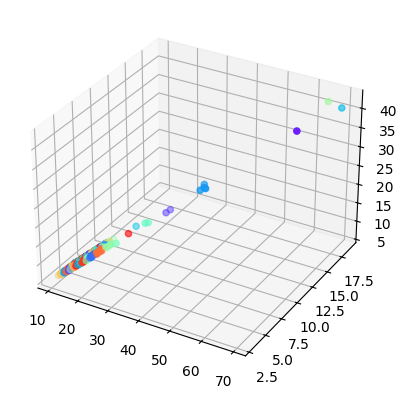

In [29]:
# visualize the clusters using first 3 dims:
%matplotlib inline  
fig = plt.figure()

ax = plt.axes(projection='3d')
ax.scatter3D(encoded_items[:,0], encoded_items[:,1], encoded_items[:,2], c=P, marker="o", picker=True, cmap="rainbow");
plt.show()

def rotate(angle):
     ax.view_init(azim=angle)

angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)
ani.save('kmeans_fig.gif', writer=animation.PillowWriter(fps=12))

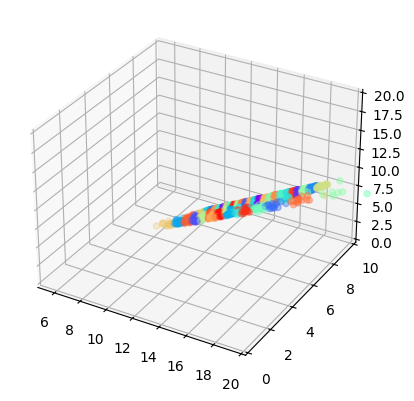

In [31]:
%matplotlib inline  
fig = plt.figure()

ax = fig.add_subplot(projection='3d')
ax.scatter3D(encoded_items[:,0], encoded_items[:,1], encoded_items[:,2], c=P, marker="o", picker=True, cmap="rainbow")
ax.axes.set_xlim3d(left=5, right=20) 
ax.axes.set_ylim3d(bottom=0, top=10) 
ax.axes.set_zlim3d(bottom=0, top=20) 
plt.show()

def rotate(angle):
     ax.view_init(azim=angle)

angle = 3
ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=50)
ani.save('kmeans_fig2.gif', writer=animation.PillowWriter(fps=12))

In [37]:
r = get_recs_lst("Team Fortress 2", encoded_items, games_features)
print("Recommendations for Team Fortress 2:")
for rec in r[0]:
    print(rec)

Recommendations for Team Fortress 2:
Terraria
Rocket League®
Warframe
PAYDAY 2
Garry's Mod
War Thunder
